In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from pytorch_model_summary import summary

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

pd.set_option("display.max_columns", None)

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pytorch_forecasting.data.examples import get_stallion_data
import numpy as np

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data = data.sort_values(["agency", "sku", "date"]).reset_index(drop=True)
data["time_idx2"]  = data["time_idx"]
df = data.copy()
data.sample(5, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency,time_idx2
168,Agency_01,SKU_03,18.3060,2017-01-01,562154016,845614054,25.824797,1625.828171,1452.080752,173.747419,153733,120207,-,-,new_year,-,-,-,-,-,-,-,-,-,10.686702,251,48,1,2.907229,1603.315368,29.919000,48
8689,Agency_26,SKU_01,0.0000,2017-02-01,530252010,850913048,23.202456,0.000000,0.000000,0.000000,32267,91330,-,-,-,-,-,-,-,-,-,-,-,-,0.000000,192,49,2,-18.420681,2634.329596,1.066500,49
3013,Agency_09,SKU_05,1164.7050,2014-02-01,425528909,734443953,32.778723,1499.660223,1340.627284,159.032939,1646094,213511,-,-,-,-,-,-,-,-,-,-,-,-,10.604598,51,13,2,7.060223,1178.701125,2101.955357,13
3382,Agency_10,SKU_04,1049.3019,2014-11-01,484133145,715784335,26.825000,2078.112851,1802.331769,275.781082,1716027,117463,-,-,-,-,-,-,revolution_day_memorial,regional_games,-,-,-,-,13.270746,132,22,11,6.955880,1006.179316,840.556125,22
9339,Agency_27,SKU_05,89.3322,2016-04-01,589172265,864686985,34.336585,1748.974189,1531.479326,217.494863,1588818,218862,-,-,-,-,-,-,-,-,-,-,-,music_fest,12.435567,168,39,4,4.492362,1207.321667,1917.619329,39


In [3]:
df.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency,time_idx2
0,Agency_01,SKU_01,80.676,2013-01-01,492612703,718394219,17.072,1141.500000,1033.432731,108.067269,153733,120207,-,-,new_year,-,-,-,-,-,-,-,-,-,9.467128,249,0,1,4.390441,2613.377501,74.82960,0
1,Agency_01,SKU_01,98.064,2013-02-01,431937346,753938444,19.984,1141.500000,1065.417195,76.082805,153733,120207,-,-,-,-,-,-,-,-,-,-,-,-,6.665160,249,1,2,4.585620,2916.978087,90.03670,1
2,Agency_01,SKU_01,133.704,2013-03-01,509281531,892192092,24.600,1179.345820,1101.133633,78.212187,153733,120207,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,6.631828,249,2,3,4.895628,3215.061952,130.48715,2
3,Agency_01,SKU_01,147.312,2013-04-01,532390389,838099501,27.532,1226.687500,1138.283357,88.404143,153733,120207,-,-,-,-,-,-,-,-,-,-,-,-,7.206737,249,3,4,4.992553,3515.822697,130.24615,3
4,Agency_01,SKU_01,175.608,2013-05-01,551755254,864420003,29.396,1230.331104,1148.969634,81.361470,153733,120207,-,-,-,-,labor_day,-,-,-,-,-,-,-,6.612974,249,4,5,5.168254,3688.107793,159.05155,4


In [6]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_unknown_reals=[
        "volume",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    # target_normalizer = None,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

from tqdm import tqdm
for x, y in tqdm(train_dataloader):
    x = x["encoder_cont"].squeeze()[:, :, 1]
    y = y[0]
    print(x.shape)
    print(y.shape)
    break

  0%|          | 0/161 [00:00<?, ?it/s]

torch.Size([128, 24])
torch.Size([128, 6])


In [5]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.linear1 = torch.nn.Linear(1, 128)
        self.linear2 = torch.nn.Linear(128, 1)
    
    def forward(self, x):
        output = self.relu(self.linear1(x))
        output = self.linear2(output)
        return output.squeeze(-1)

model = Model()
summary(model,
        x.unsqueeze(-1),
        show_parent_layers=True, print_summary=True)

---------------------------------------------------------------------------------------
   Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
           Model           Linear-1      [128, 24, 128]             256             256
           Model             ReLU-2      [128, 24, 128]               0               0
           Model           Linear-3        [128, 24, 1]             129             129
Total params: 385
Trainable params: 385
Non-trainable params: 0
---------------------------------------------------------------------------------------


'---------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #\n=======================================================================================\n           Model           Linear-1      [128, 24, 128]             256             256\n           Model             ReLU-2      [128, 24, 128]               0               0\n           Model           Linear-3        [128, 24, 1]             129             129\n=======================================================================================\nTotal params: 385\nTrainable params: 385\nNon-trainable params: 0\n---------------------------------------------------------------------------------------'

0.7963637113571167


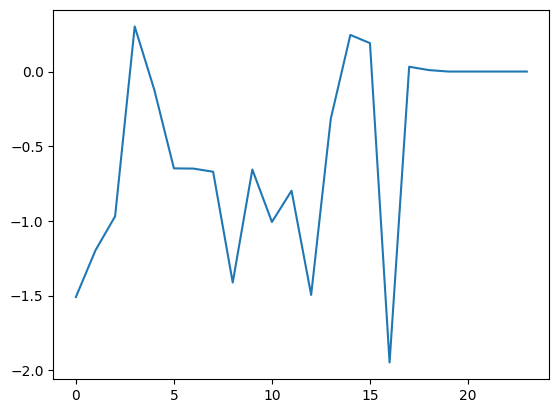

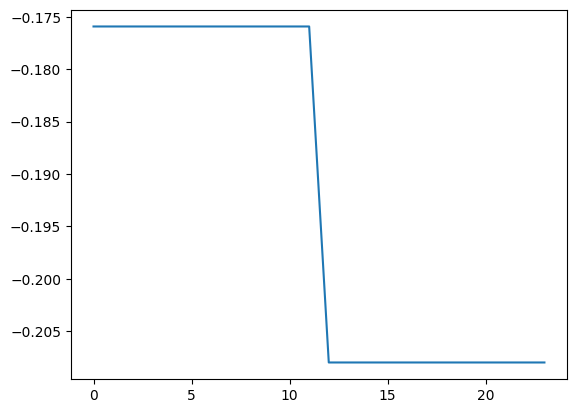

100%|██████████| 161/161 [00:05<00:00, 27.72it/s]


In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
mse_loss = torch.nn.MSELoss()

def train():
    pbar = tqdm(train_dataloader)
    for n, (x, y) in enumerate(pbar):
        x_raw = x["encoder_cont"].squeeze()[:, :, 1]
        x = x_raw[:-10]
        y = x_raw[10:]

        model.train()
        optimizer.zero_grad()
        pred = model(x.unsqueeze(-1))
        loss = mse_loss(pred, y)
        loss.backward()
        optimizer.step()

        if n % 10 == 0:
            clear_output(wait=True)
            print(loss.item())
            plt.plot(y[-1])
            plt.show()
            plt.plot(pred[-1].detach().cpu().numpy())
            plt.show()

for i in range(1):
    train()